# Multiple Sample Analysis
---
This notebook anlyzes statistics of Noisy [1,2] Gaussian Random Fields movies.

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [3]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy as sci
from ipywidgets import interact, fixed
import ipywidgets as widget
import pynoisy.eht_functions as ehtf
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.optimize import minimize

In [4]:
def compare_movie_frames(movie1, movie2):
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    plt.tight_layout()
    mean_images = [movie1.frames.mean(axis=0), 
                   movie2.frames.mean(axis=0), 
                   (np.abs(movie1.frames - movie2.frames)).mean(axis=0)]
    cbars = []
    for ax, image in zip(axes, mean_images):
        im = ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbars.append(fig.colorbar(im, cax=cax))
                     
    def imshow_frame(i, movie1, movie2, axes, cbars):
        image1 = movie1.frames[i]
        image2 = movie2.frames[i]
        image3 = np.abs(movie1.frames[i] - movie2.frames[i])
        
        for ax, img, title, cbar in zip(axes, [image1, image2, image3], 
                                        ['Movie1', 'Movie2', 'Absolute difference'], cbars):
            im = ax.imshow(img)
            ax.set_title(title)
            cbar.mappable.set_clim([img.min(), img.max()])
            
    interact(
        imshow_frame, i=(0, pynoisy.core.get_num_frames()-1), 
        movie1=fixed(movie1),movie2=fixed(movie2), axes=fixed(axes), cbars=fixed(cbars)
    );
    
class Optimizer(object):
    def __init__(self):
        self._nfeval = 0
        
    def objective_fun(self, x):
        diffusion = pynoisy.RingDiffusion(opening_angle=x)
        forward_solver = pynoisy.PDESolver(advection=advection_true, diffusion=diffusion)
        adjoint_solver = pynoisy.PDESolver(advection=-advection_true, diffusion=diffusion)
        random_field = forward_solver.run_adjoint(source=source, verbose=False)
        error = random_field.frames - random_field_true.frames
        loss = np.abs(error).mean()
        backprop = adjoint_solver.run_adjoint(source=pynoisy.Movie(error).reverse_time().frames, verbose=False)
        #backprop = forward_solver.run_adjoint(source=error, verbose=False)
    
        dx = 1e-2
        diffusion_f = pynoisy.RingDiffusion(opening_angle=x+dx)
        jac_source = (diffusion_f.get_laplacian(random_field.frames, advection_true.v) - 
                      diffusion.get_laplacian(random_field.frames, advection_true.v)) / dx
        gradient = np.mean(backprop.frames * np.flip(jac_source, axis=0))
        #gradient = np.mean(backprop.frames * jac_source)
        return np.array(loss), np.array(gradient)

    def callback_fun(self, x):
        print('{}    {}'.format(self._nfeval, x))
        self._nfeval += 1
        
    def minimize(self, x0):
        result = minimize(fun=self.objective_fun, x0=np.array(x0), method='L-BFGS-B', jac=True)
        return result

## Forward Model

In [13]:
advection = pynoisy.DiskAdvection()
diffusion = pynoisy.RingDiffusion()
solver = pynoisy.SamplerPDESolver(advection, diffusion, num_samples=1000)
multi_sample = solver.run(n_jobs=12)

100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]


<IPython.core.display.Javascript object>


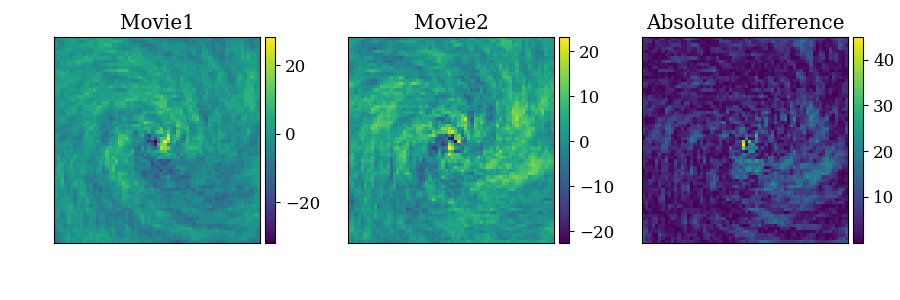

interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

In [6]:
%matplotlib notebook
compare_movie_frames(b[0], b[1])

<IPython.core.display.Javascript object>


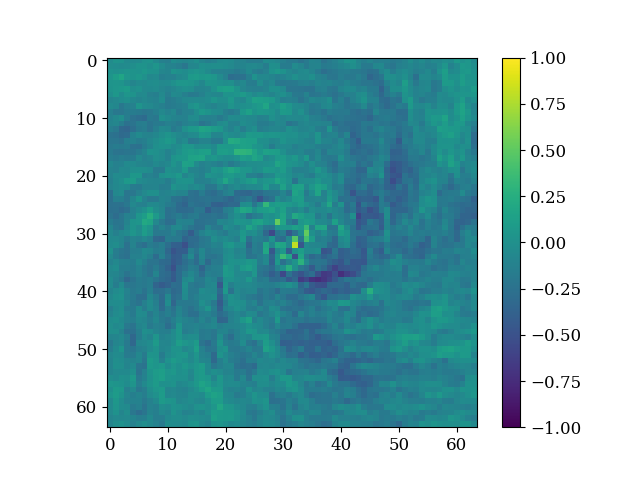

In [20]:
multi_sample.mean().get_animation(vmin=-1, vmax=1, output='./mean_1000sim.gif')

<IPython.core.display.Javascript object>


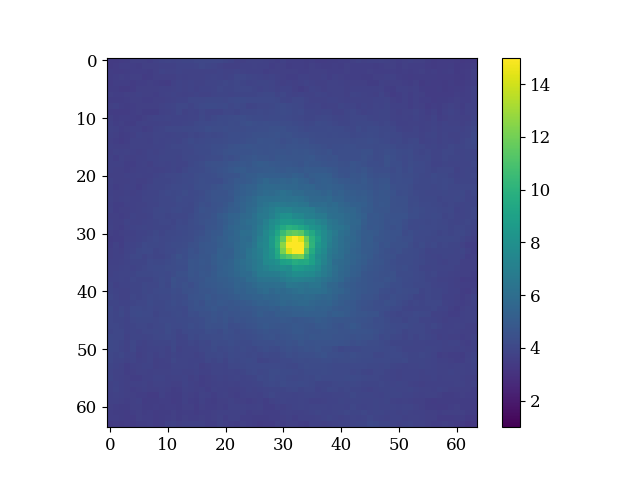

In [25]:
multi_sample.std().get_animation(vmin=1, vmax=15, output='./std_1000sim.gif')

## Inverse Model

In [ ]:
"""
Optimization from many initial guesses. 
"""
optimizer = Optimizer()
x0_list = np.linspace(0.0, np.pi, 30)
results = []
for x0 in tqdm(x0_list):
    res = optimizer.minimize(x0)
    results.append(res.x)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\hat{\theta}$')
ax.set_title('Convergence of different initial conditions')
ax.plot(x0_list, np.array(results))
plt.axhline(y=diffusion_true.opening_angle, color='r', linestyle='--', label='True angle')
plt.axvline(x=diffusion_true.opening_angle, color='r', linestyle='--', label='True angle')